# Estimating $\pi$ in Parallel

The power of the Monte Carlo method is that we can sample our population multiple times, estimate our target and then look at the variance between those estimations. This will give us a clearer answer than just picking a number of darts and hoping that sample size is effective.

In fact, you did this before in the previous notebook. However before, you did this all on a single thread in serial (one after the other). What if instead you could carry out many of these tasks at the same time (in parallel). The beauty of modern computers is that you can easily exploit multiple threads either with multiple processors or with multiple cores to reduce the *real* elapsed time. 

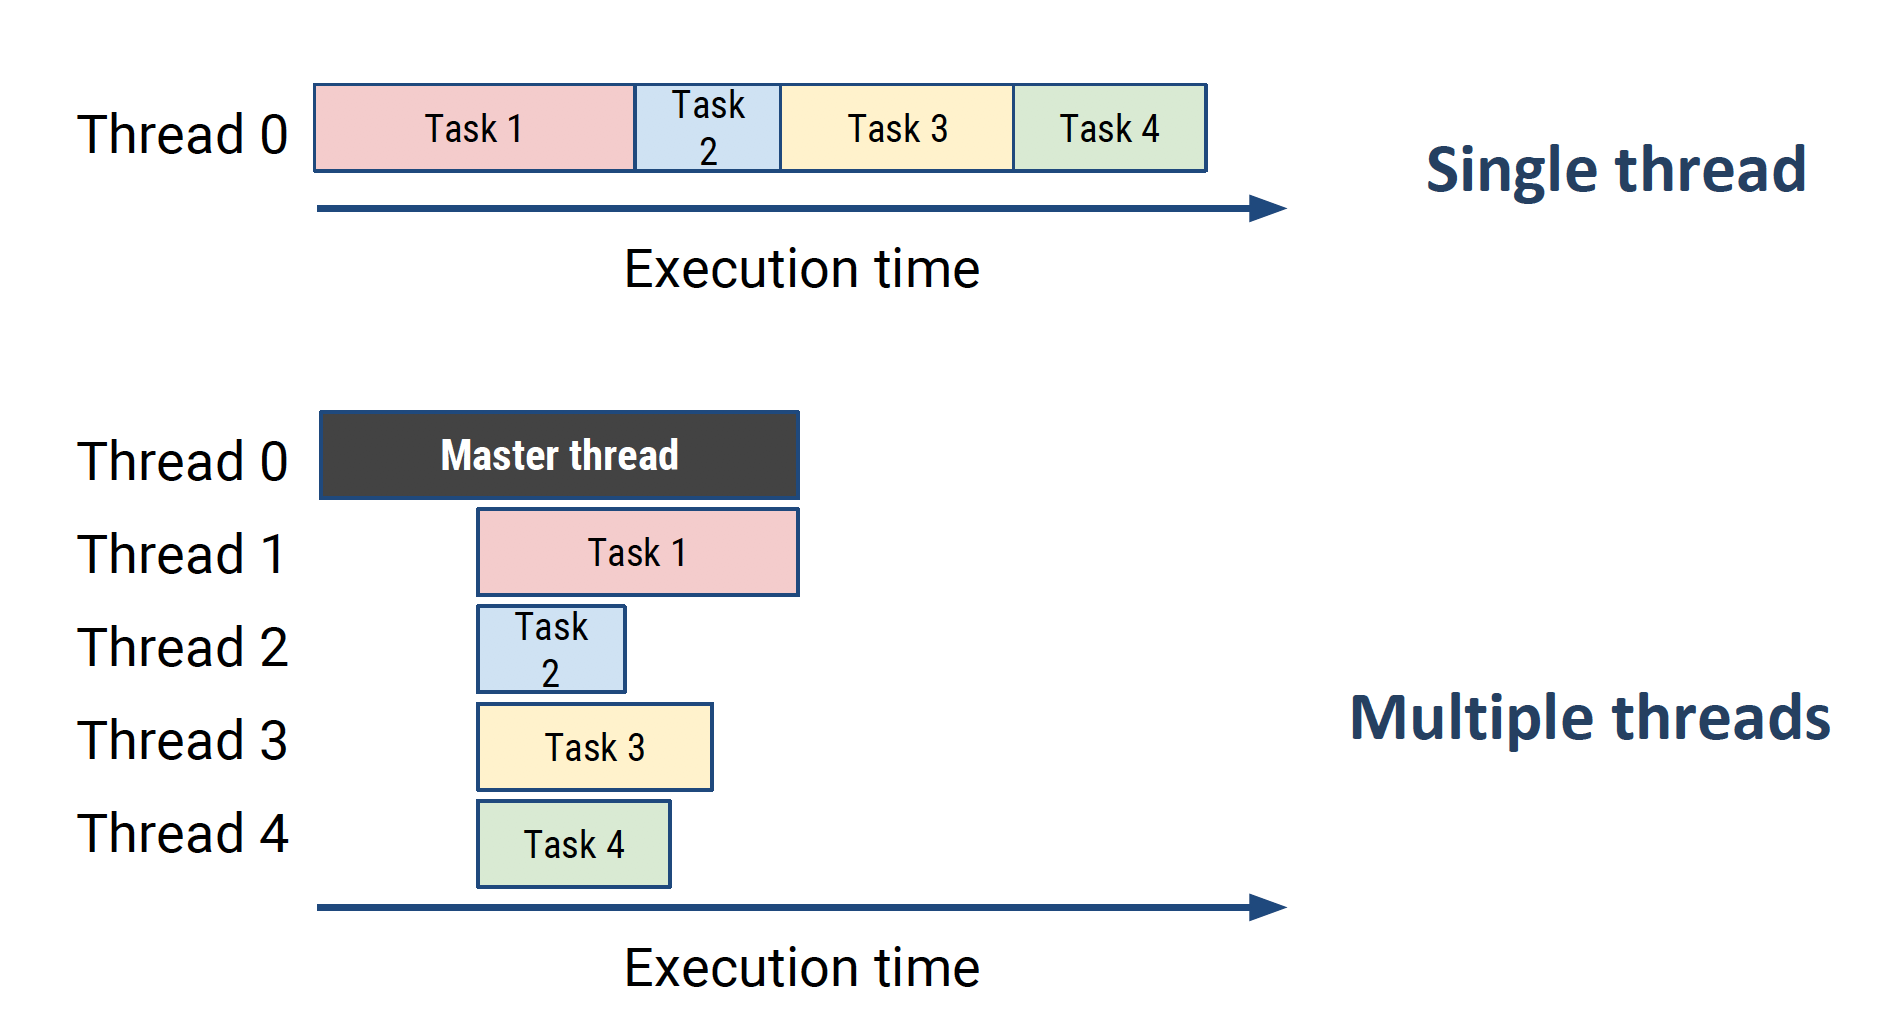

As the image above shows, if we can break up the tasks in our code to run on separate threads at the same time, we can potentially make the code run faster. This can sometimes be difficult to implement and it isn't always better to run this way. However, for some jobs, we can significantly speed up our code and also expand onto large parallel systems, like supercomputers, to calculate very large systems.

This is why Monte Carlo calcuations are very popular in supercomputing scale applications, because it is fairly easy (**trivial**) to scale them up and the individual processes are **independent** so they can run at the same time without dependencies. But how do we parallelize our code?

### MPI4Py
We will use the parallel processing tool MPI4Py which is an implementation of MPI in Python. MPI stands for Message Passing Interface and is basically a way to get multiple processing units, in this case cores, to share the workload and communicate with each other. The processors are given "ranks". The rank 0 processor is the master processor and sends and receives information from each of the worker processors.

Below is an example of how MPI is implemented in our parallel code. The number of samples is distributed evenly across all of the available processes. At the end of each run, the evaluation of $\pi$ is averaged (summed then divided by the number of ranks) and stored in the `pi_ests` array.

``` import mpi4py as MPI
    import numpy as np

    comm = MPI.COMM_WORLD  # sets up communication between the processors
    size = comm.Get_size() # gives number of ranks in comm
    rank = comm.Get_rank() # identifies ranks of the processors, starting with 0
    
    # set the number of runs
    n_ests = 200

    # array for values of pi in each run
    pi_ests = []
    
    n_samples = 100000000
    count = int(np.floor(n_samples/size))
    remainder = n_samples % size

    # loop over number of runs and add 
    # pi value to the pi_ests array
    for i in range(n_ests):   

        # Calculate the approximate value of pi
        if rank < remainder:
            pi_approx = monte_carlo_pi(count + 1)
        else:
            pi_approx = monte_carlo_pi(count)
            
    # Reduce the approximations from all processes to get the final approximation
    pi_final = comm.reduce(pi_approx, op=MPI.SUM)
    
    if rank==0:
        pi_ests.append(pi_final/size)
 ```

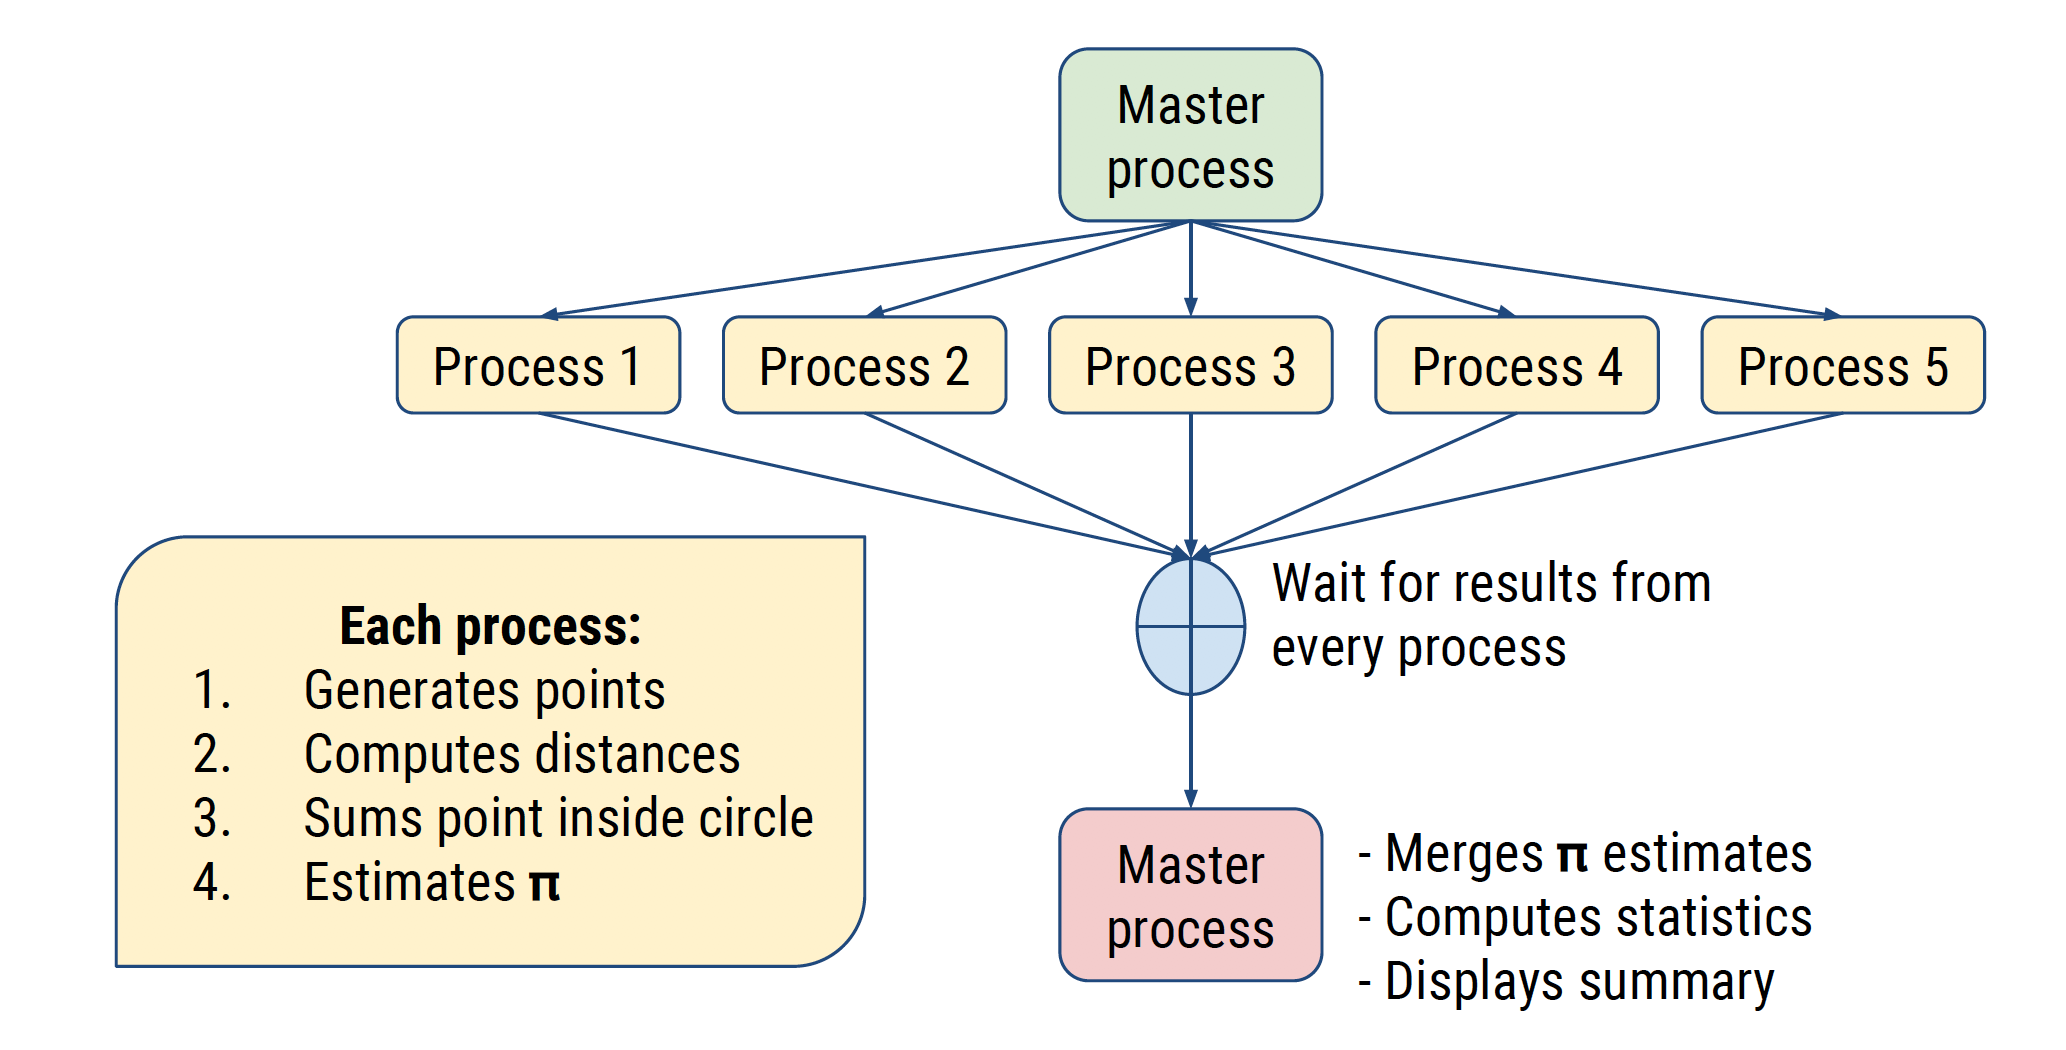

## Moving to the Supercomputer

To run our Monte Carlo $\pi$ python program on the supercomputer NCSA Delta, we will need to do the following:
   1. Log into NCSA Delta
   2. Clone our GitHub repository.
   3. Request an interactive session.
   4. Execute the parallel Monte Carlo program.
   5. Record calculation statistics.

### 1. Log into NCSA Delta

In your terminal or powershell prompt, ssh into the Delta supercomputer: `ssh $USER@login.delta.ncsa.illinois.edu`. Type in your password at the prompt and select the Duo Push option for two-factor authentication and then accept the connection.

### 2. Clone our GitHub repository.
Once you have logged into Delta, you will be in your home directory. Clone the Git repo using the following command: `git clone https://github.com/CSULA-MolSSI-PREC/intro-to-HPC/`. This should download the Intro-to-HPC folder to your home directory. Navigate to this folder with `cd intro-to-HPC`.

### 3. Request an interactive session
We will be running our Monte Carlo $\pi$ programs interactively on the compute nodes of Delta. **Note: when running computationally intensive calculations, avoid using the login nodes. This is highly frowned upon.** 

To request an interactive session, copy the following command, and paste and execute it at your command prompt: `srun -A bbow-delta-gpu --time=00:30:00 --partition=gpuA40x4-interactive --nodes=1 --ntasks-per-node=16 --gpus-per-node=1 --mem=32g --pty /bin/bash`.

This will request 30 minutes, 16 cores, and 32 GB of memory on a single NVIDIA A40 GPU Compute Node.

Once the resources for your job have been allocated, load the python library: `module load python`.

### 4. Execute the parallel Monte Carlo program

To run the parallel Monte Carlo program, you only need to execute the following command:

`mpirun -np N python estimate_pi_parallel.py`

where N is the number of tasks you want to use. N = 1 implies a serial version of the code. N = 16 indicates that 16 processes are running at the same time in parallel. Execute the program first with N = 1, then double N and run it again, over and over until you reach N = 16. 

### 5. Record calculation statistics

Since the number of runs and the number of samples were unchanged, the accuracy of pi should change very little depending on the number of processors. However, the **real** elapsed time of the calculations should have change dramatically. 

Use the table below, show the speedup of the parallelization.

| Number of Cores     | Time (s) |
|---------------------|----------|
| <center>1</center>  | 138.880087        |
| <center>2</center>  | 71.123357         |
| <center>4</center>  | 33.742159         |
| <center>8</center>  | 16.932443         |
| <center>16</center> | 8.797376          |

## Visualizing Output

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cores = np.array([1,2,4,8,16])

# add times to array below
times = np.array([])

plt.xlabel('Number of processors')
plt.ylabel('Compute time (s)')
plt.scatter(cores,times)
plt.show()

We can compute the speedup of our caluclation by the ratio of the time required to compute some function using a single processor ($t_s$) divided by the time required to compute it in parallel using $n$ processors ($t_p(n)$). That is:

$$ S(n) = \frac{t_s}{t_p(n)} $$

In [ ]:
speedup = times[0]/times

plt.figure(figsize=(7,7))
plt.plot([-100,100], [-100,100], '--', c='black')
plt.scatter(cores,speedup, c='green')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xlabel('Number of processors')
plt.ylabel('Speedup')
plt.show()

The parallel efficiency of our calculations can be computed for a program as the ratio of the ratio of the speedup factor ($S(n)$) and the number of processors ($n$). 

$$ \eta_S = \frac{S(n)}{n} $$

In [ ]:
efficiency = speedup/cores

plt.xlabel('Number of processes')
plt.ylabel('Parallel Efficiency')
plt.scatter(cores,efficiency, c='violet')
plt.show()


## Your turn #1: a more efficient approach?
Now try to estimate $\pi$ with the more efficient Monte Carlo method discussed before. This can be found in the GitHub repo as `estimate_pi_revised_parallel.py`. Run the program with 1, 2, 4, 8, and 16 cores. Record the statistics and chart the Elapsed time, Speedup and Parallel efficiency vs. the number of processors. **How do these results compare to the original Monte Carlo program?**